In [1]:
# -*- coding: utf-8 -*-
from io import BytesIO
from tensorflow.python.lib.io import file_io
from tqdm.auto import tqdm
from configuration import Config
from Simulation.model import LuxuryDiceSimulationMdn as Model
from Simulation.loss import MdnLoss

import tensorflow_probability as tfp
import os
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

In [3]:
#
# Configuration Loading
# ----------------------------------------------------------------------------------------------------------------------
config = Config(os.path.join(os.getcwd(), "Simulation/config.yaml"))

# # Set GPU as available physical device
# if cpus := tf.config.experimental.list_physical_devices(device_type='CPU'):
#     tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='CPU')
# tf.config.run_functions_eagerly(True)
# tf.config.set_soft_device_placement(False)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

---------------------------------- APP CONFIG ----------------------------------
data: 
  data_path: gs://bin_for_aiops/GambleMaster/LuxuryDice/luxury_dice_v2.npz
  time_length: 15
  train_test_split: 0.8
train: 
  batch_size: 256
  epoch: 3000
test: 
  batch_size: 128
model: 
  loss: MDN
  metrics: MDN
  focal_weight: 5
optimizer: 
  method: adam
  learning_rate: 1e-4
weights: 
  simulation: weights/best_luxury_dice_simulation_model.tf
--------------------------------------------------------------------------------


In [4]:
f = BytesIO(file_io.read_file_to_string(config.data.data_path, binary_mode=True))
data = np.load(f)
x, time_encode, y = data["record"], data["time_code"], data["y"]
x = tf.cast(x, tf.float32)
time_encode = tf.cast(time_encode, tf.float32)
y = tf.cast(y, tf.float32)

2023-12-24 10:07:48.030383: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-24 10:07:48.030439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gamble-master
2023-12-24 10:07:48.030448: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gamble-master
2023-12-24 10:07:48.030614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2023-12-24 10:07:48.030646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2023-12-24 10:07:48.030652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2023-12-24 10:07:48.031017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

In [5]:
k = int(config.data.train_test_split * x.shape[0])
x_train, x_test = x[:k, :, :], x[k:, :, :]
time_encode_train, time_encode_test = time_encode[:k, :], time_encode[k:, :]
y_train, y_test = y[:k, :], y[k:, :]

In [6]:
x_test.shape

TensorShape([44979, 15, 16])

In [7]:
time_encode_test.shape

TensorShape([44979, 2])

In [6]:
model = tf.keras.models.load_model('weights/best_luxury_dice_simulation_model.tf')
mu_hat, sigma_hat = model(x_test, time_encode_test)

2023-12-18 05:35:55.839706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
dist = tfp.distributions.Beta(mu_hat, sigma_hat)
beta = dist.sample()

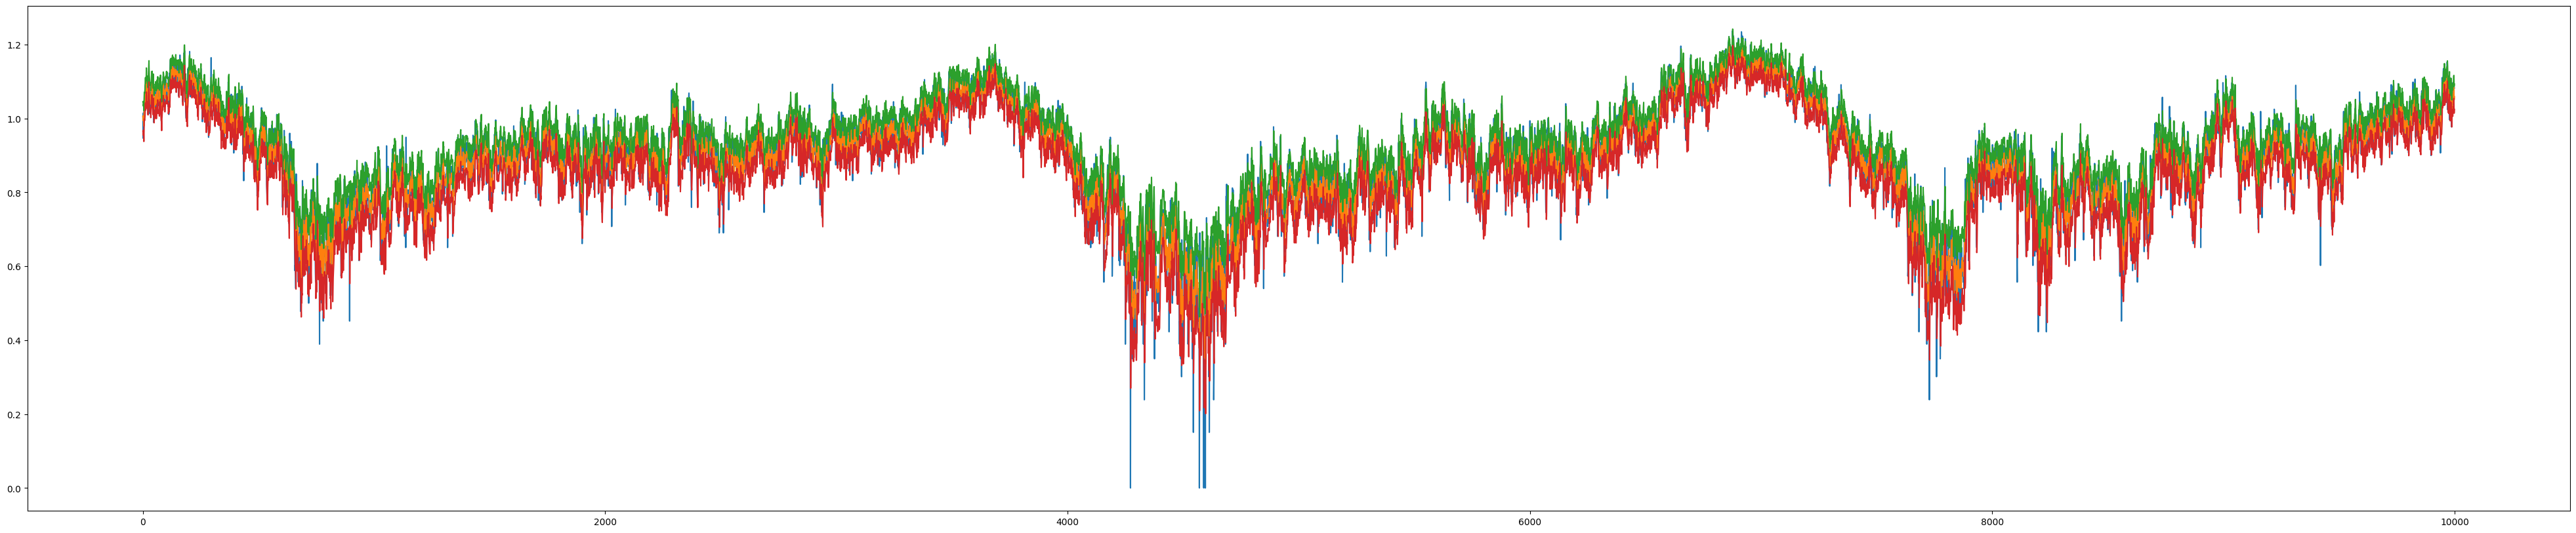

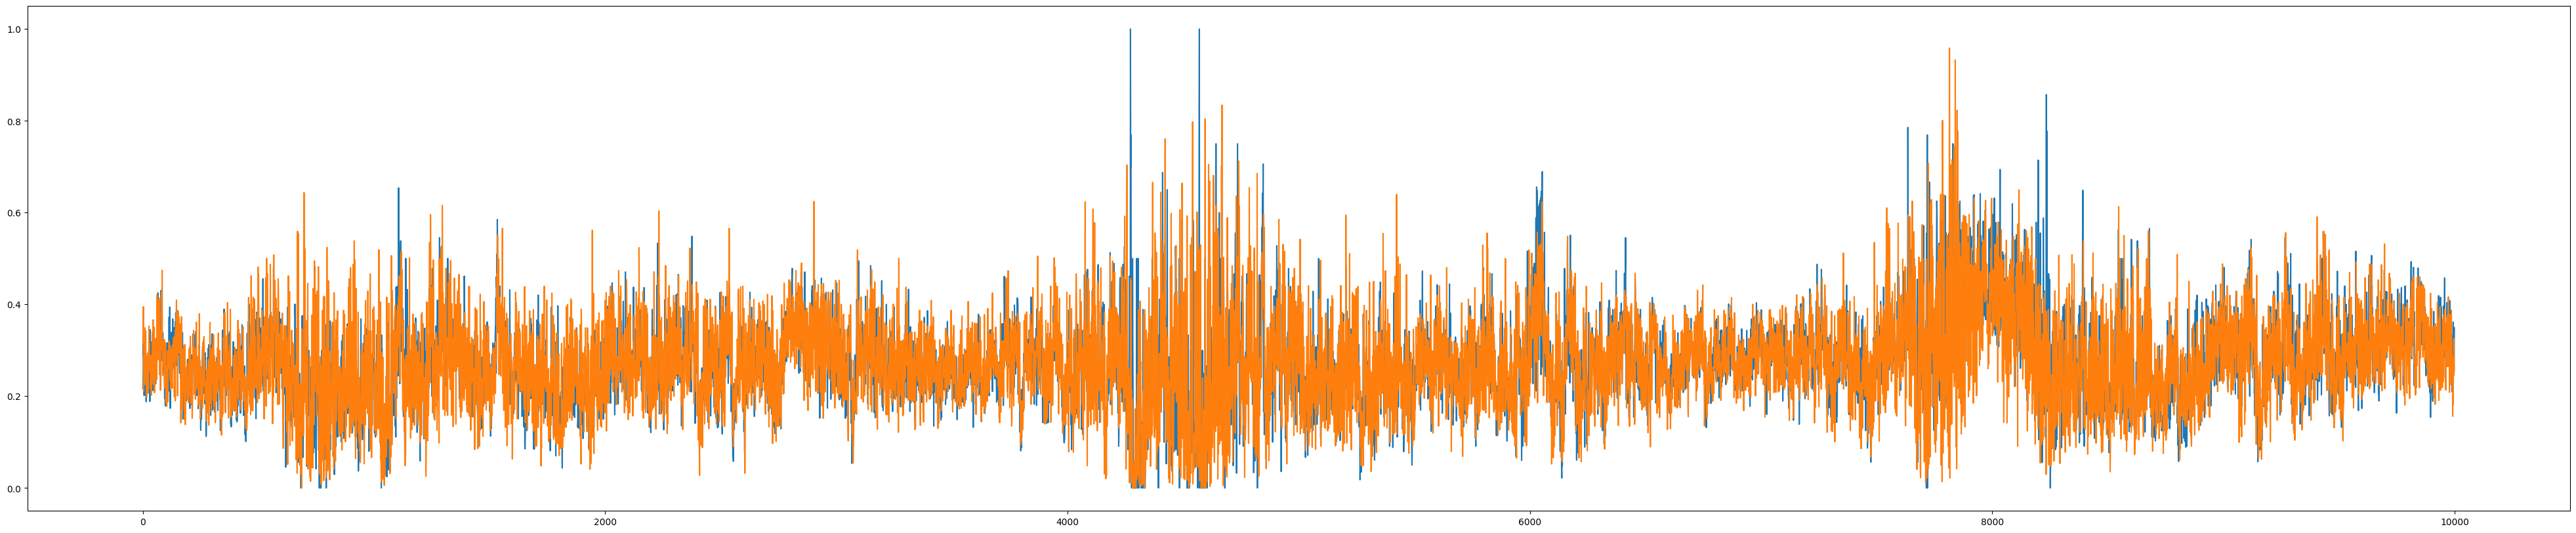

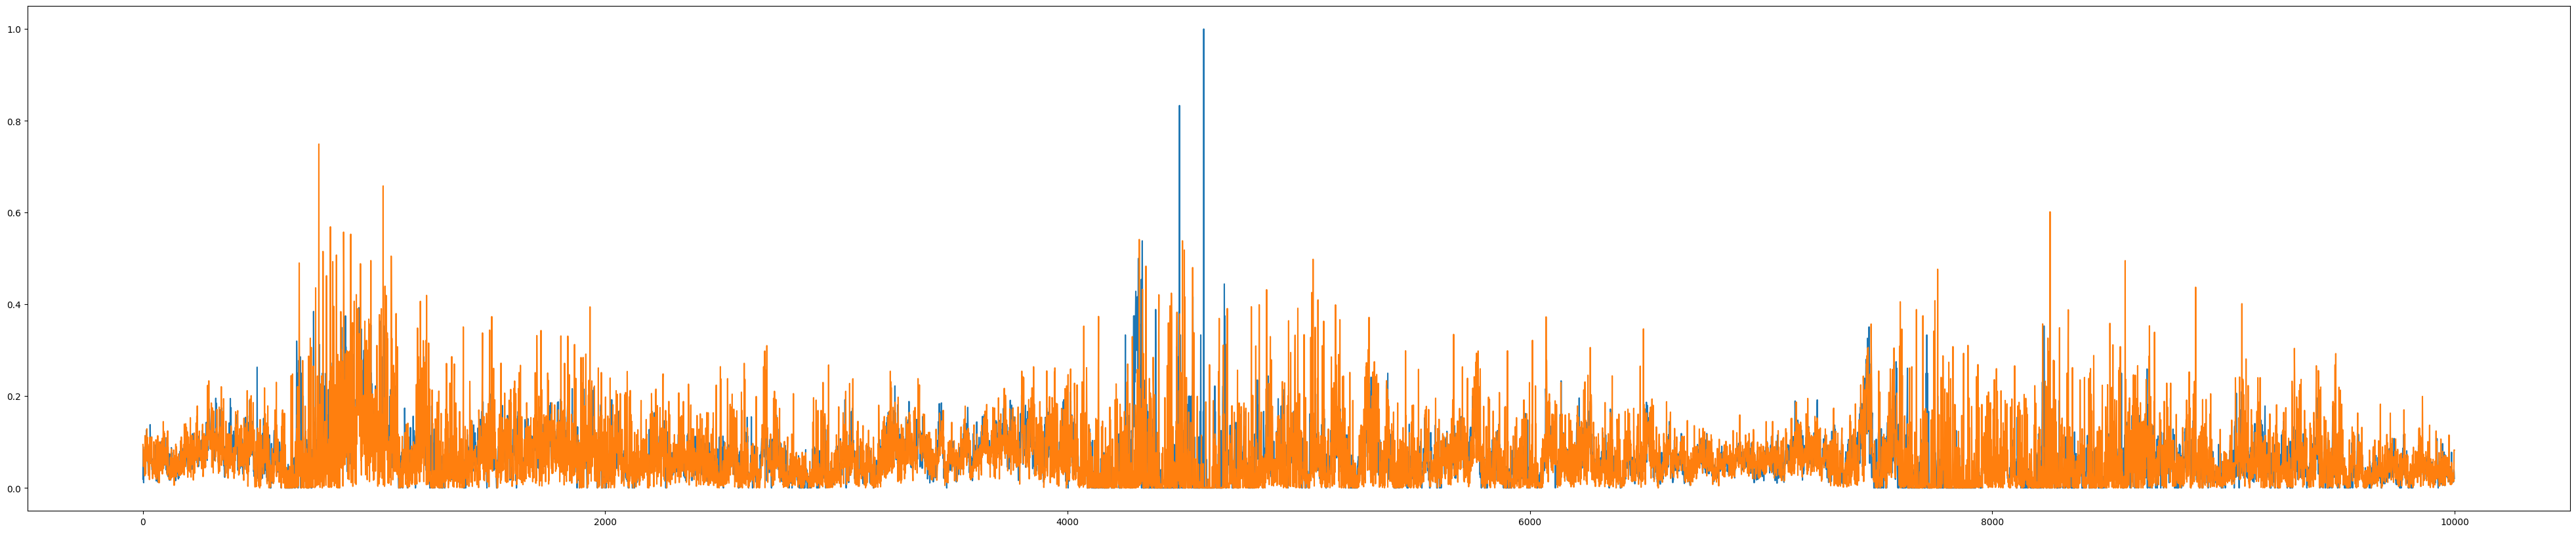

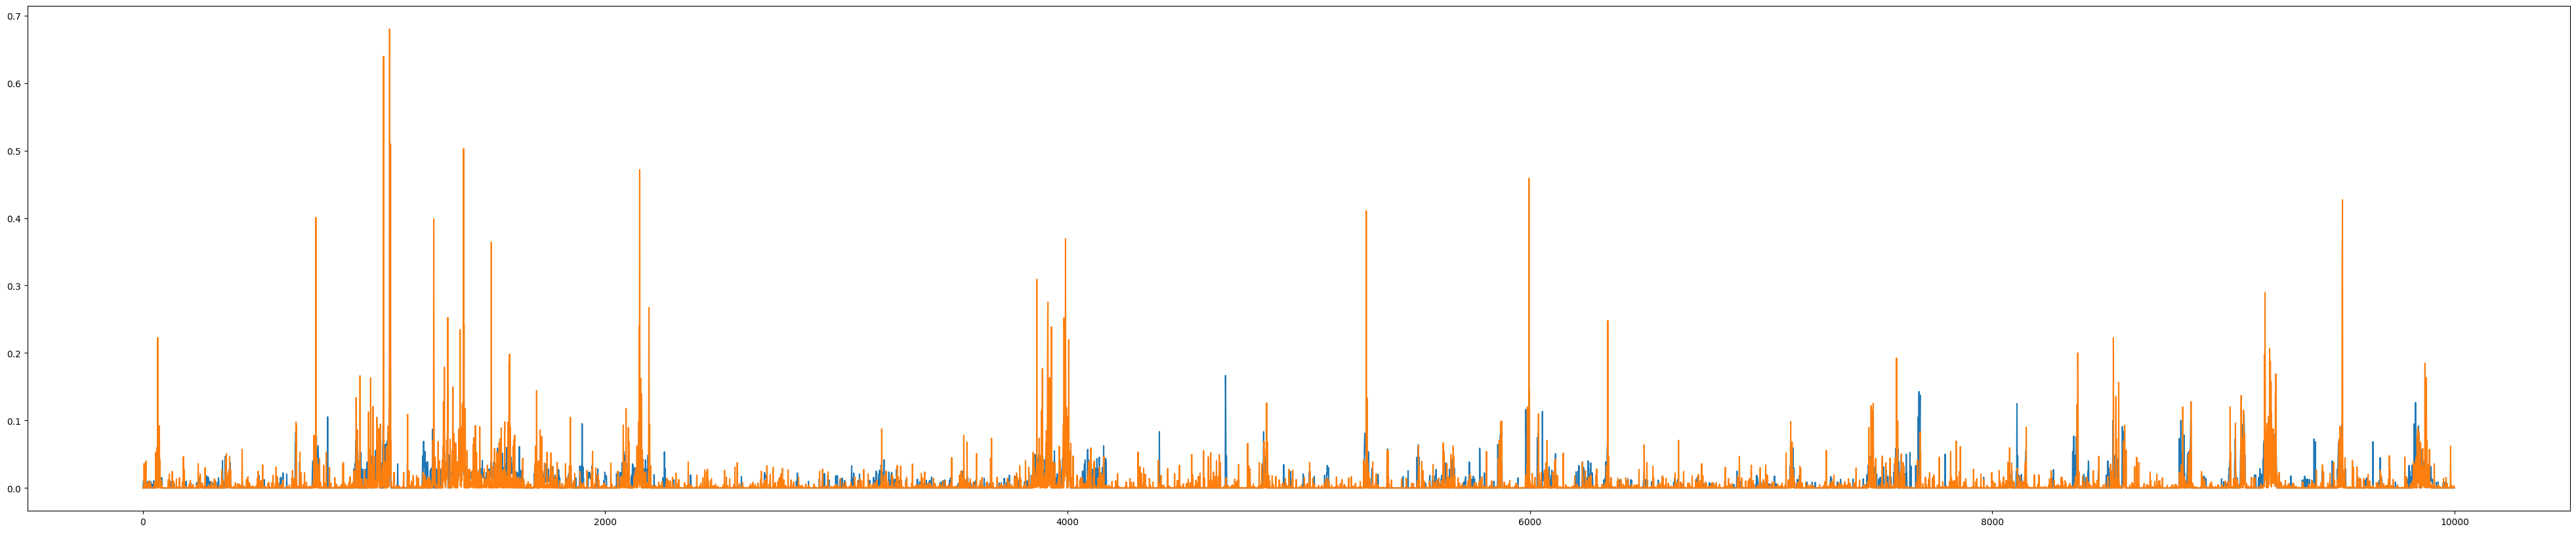

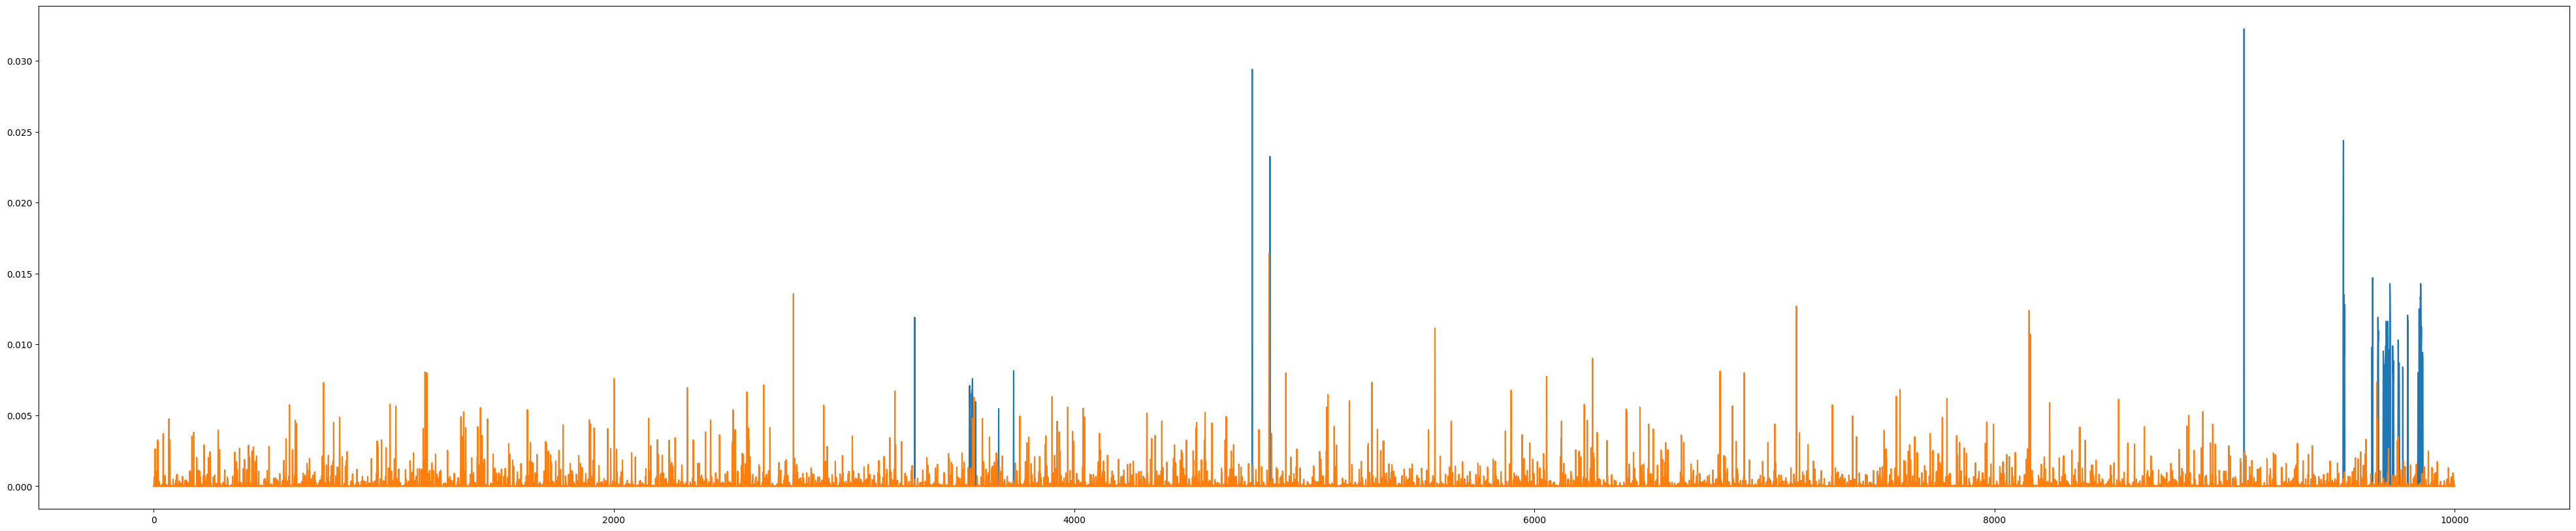

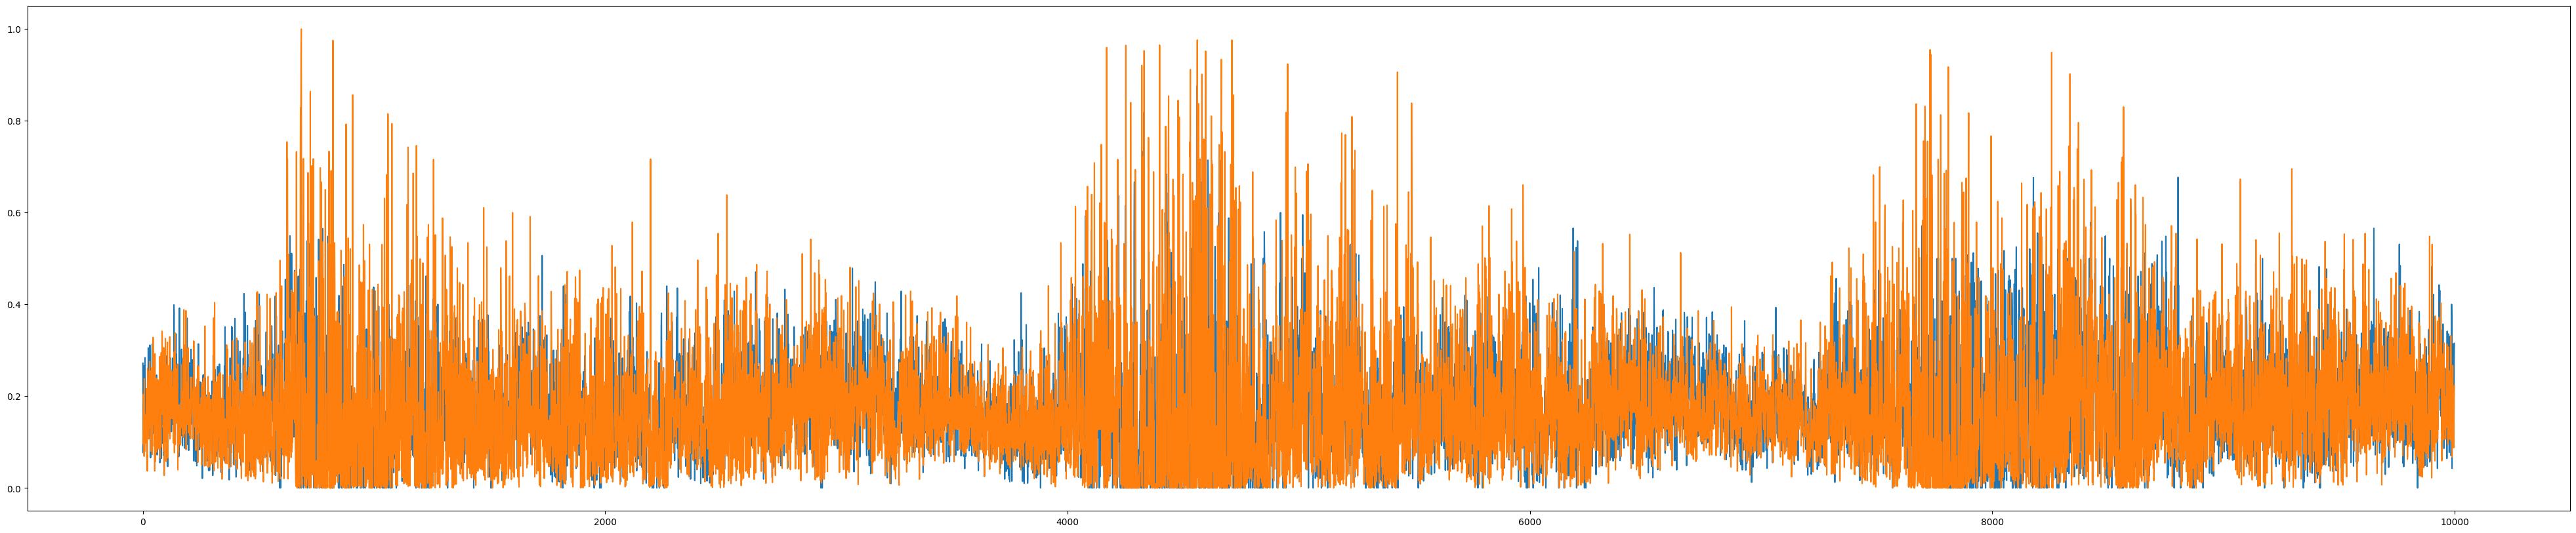

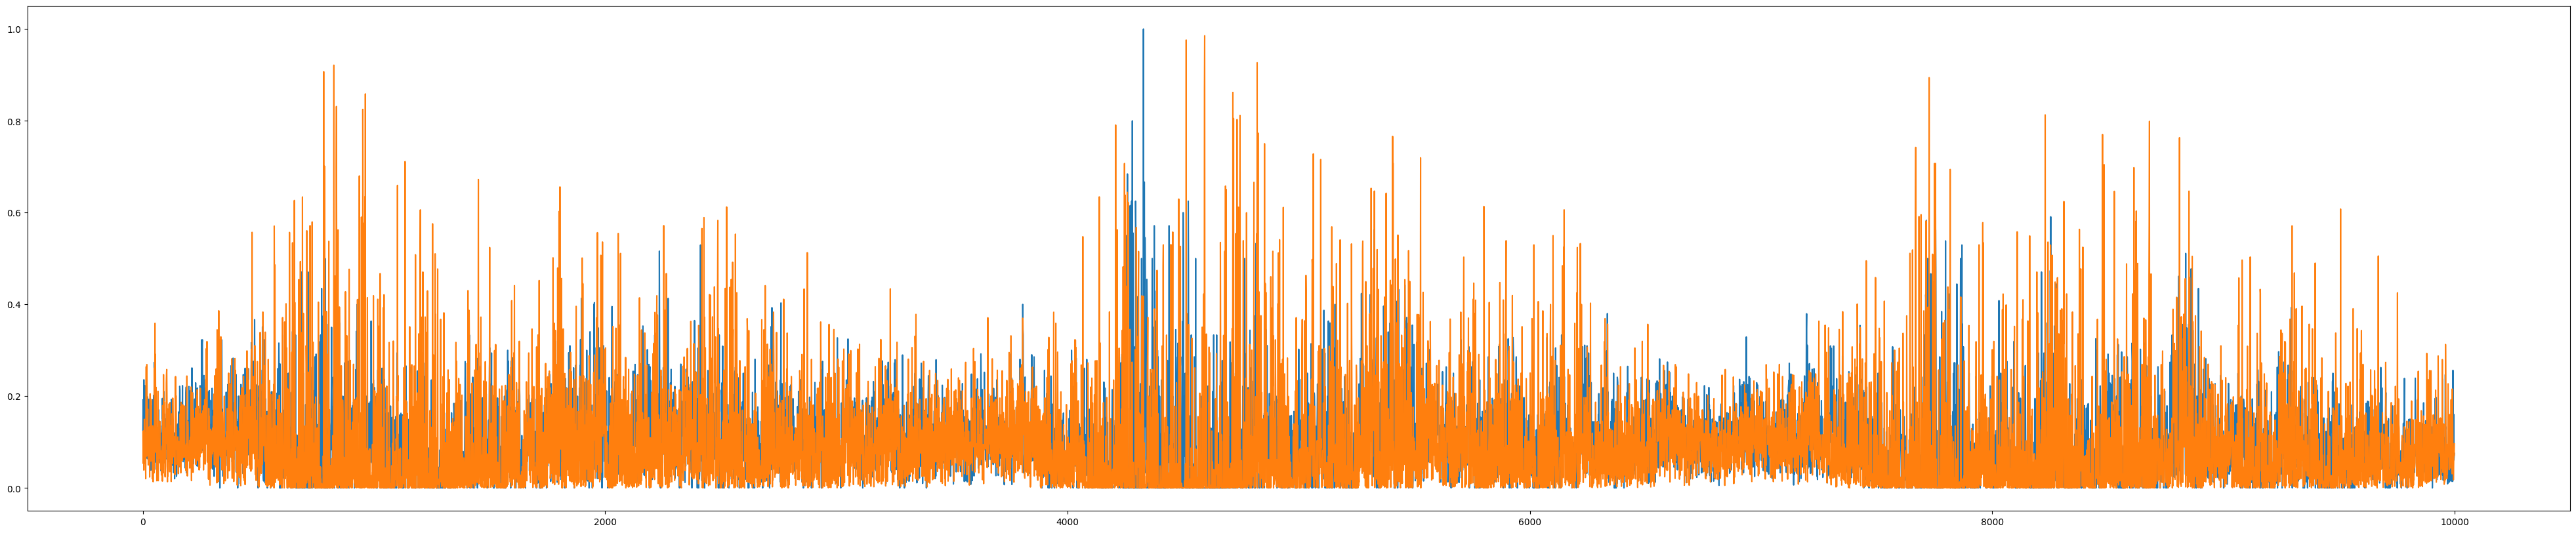

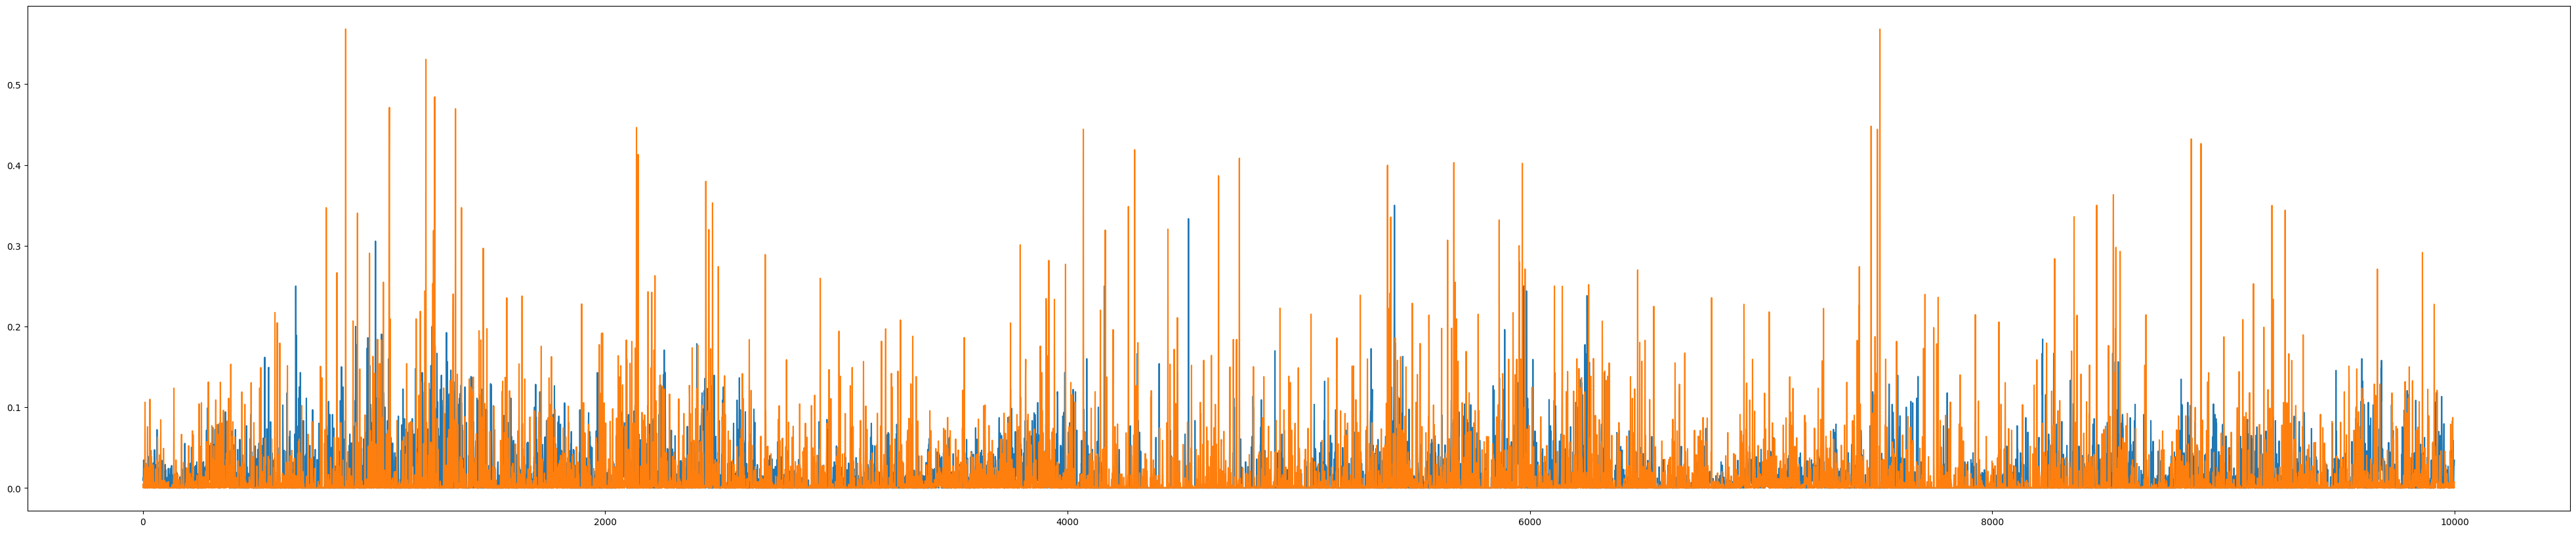

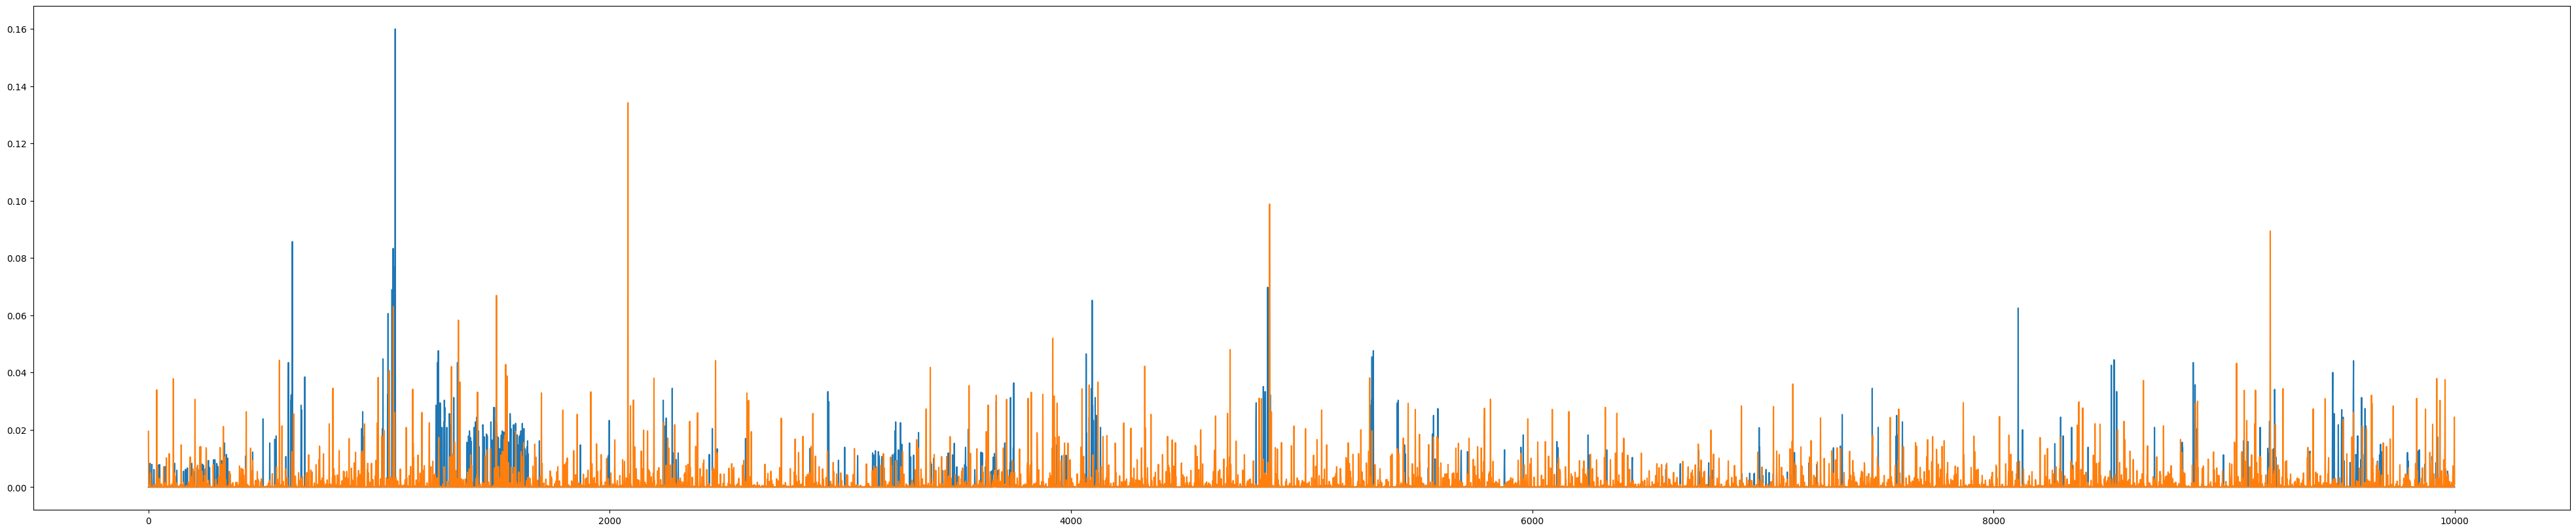

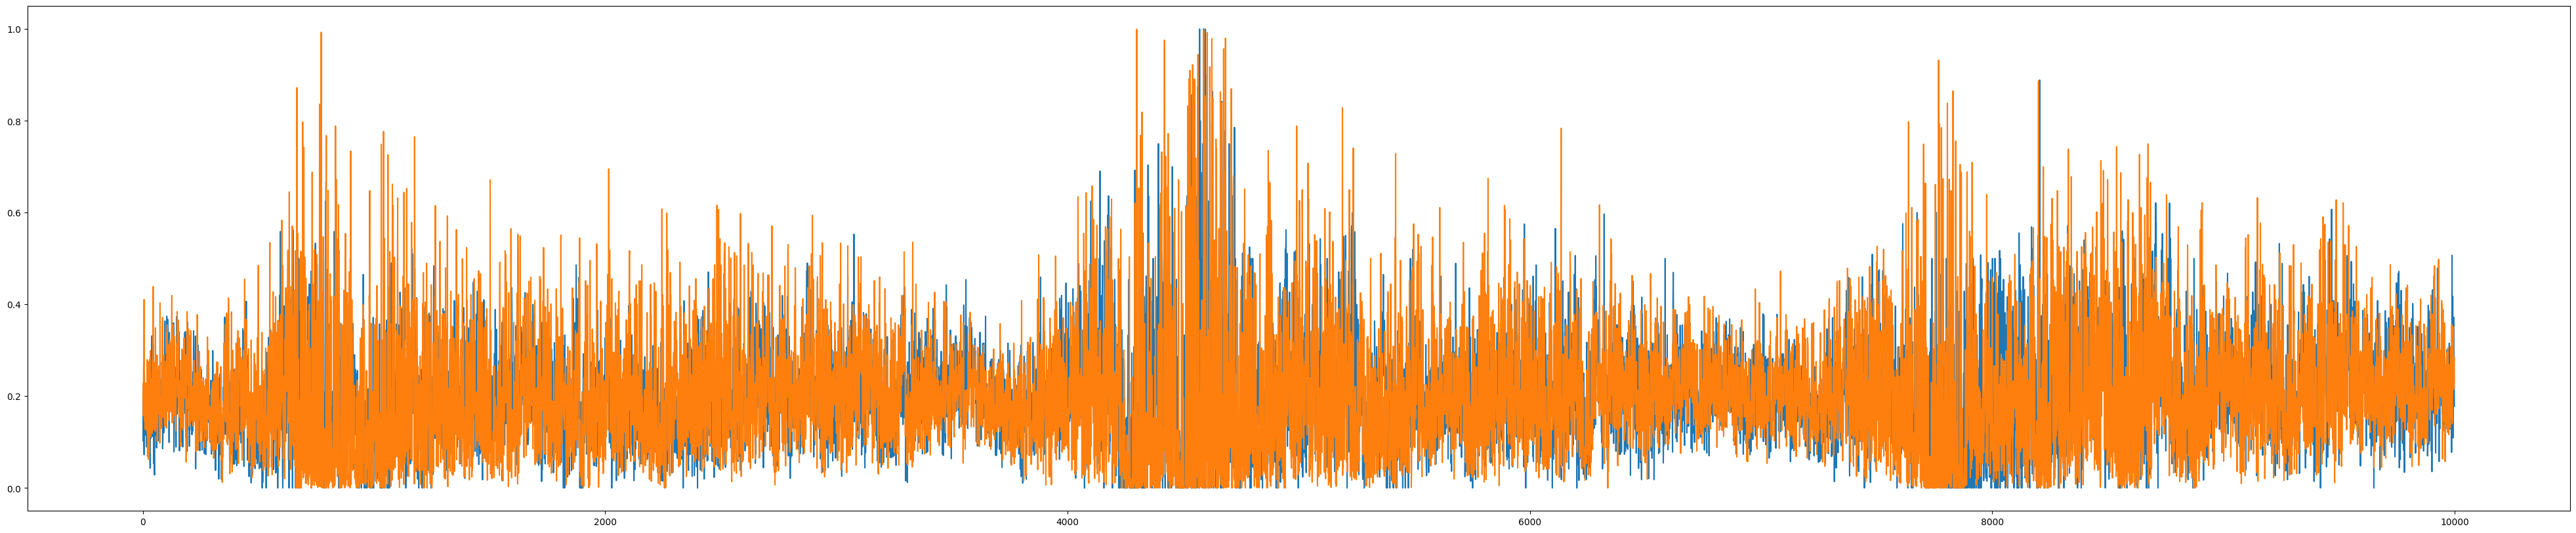

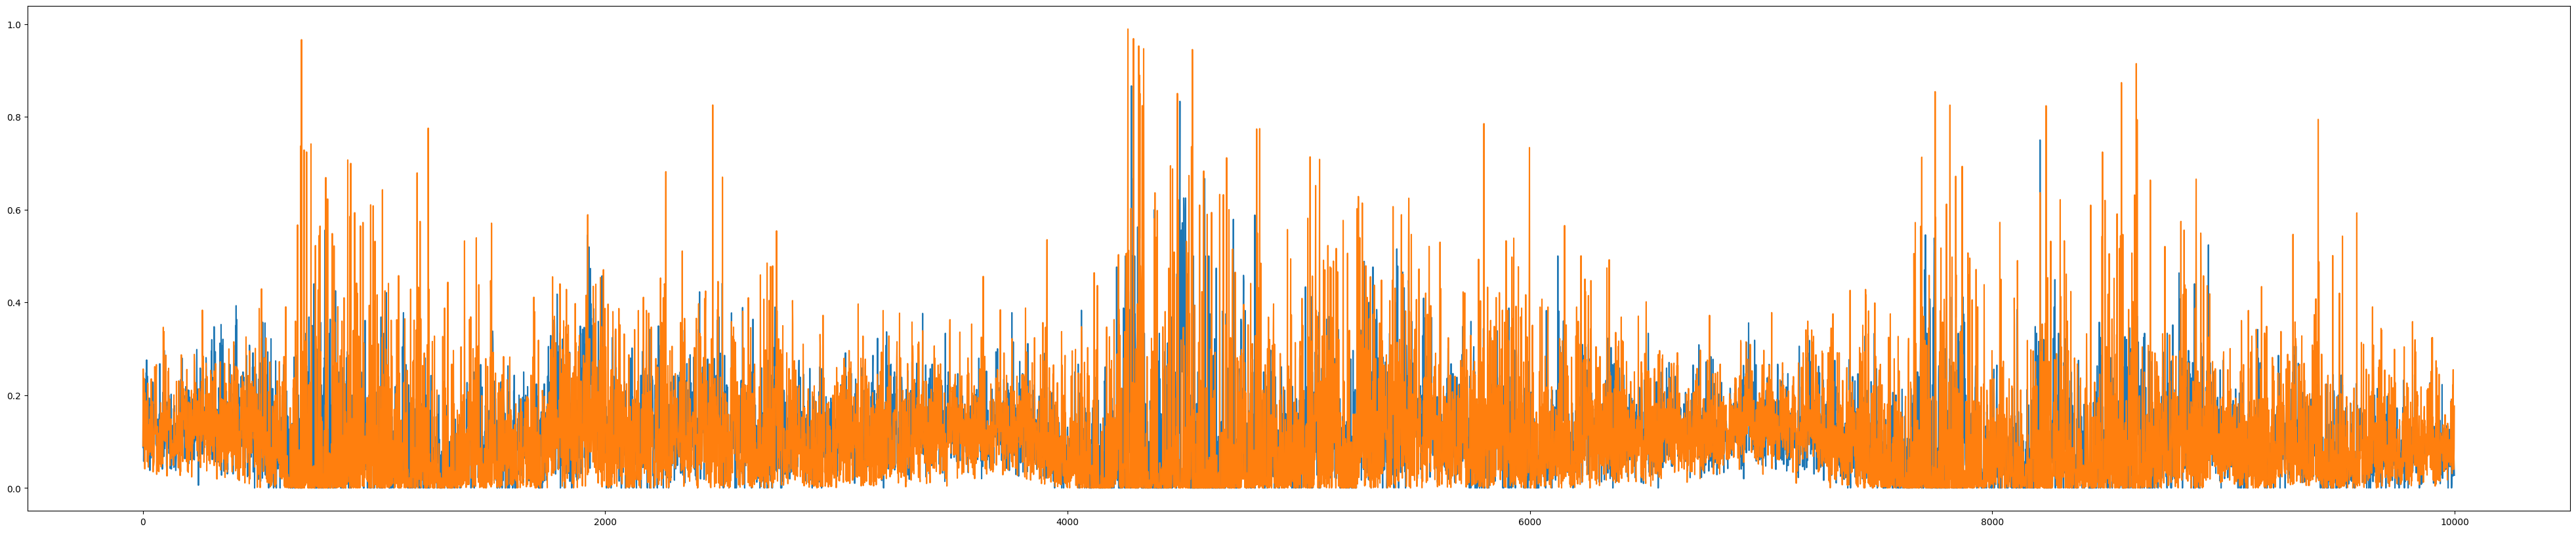

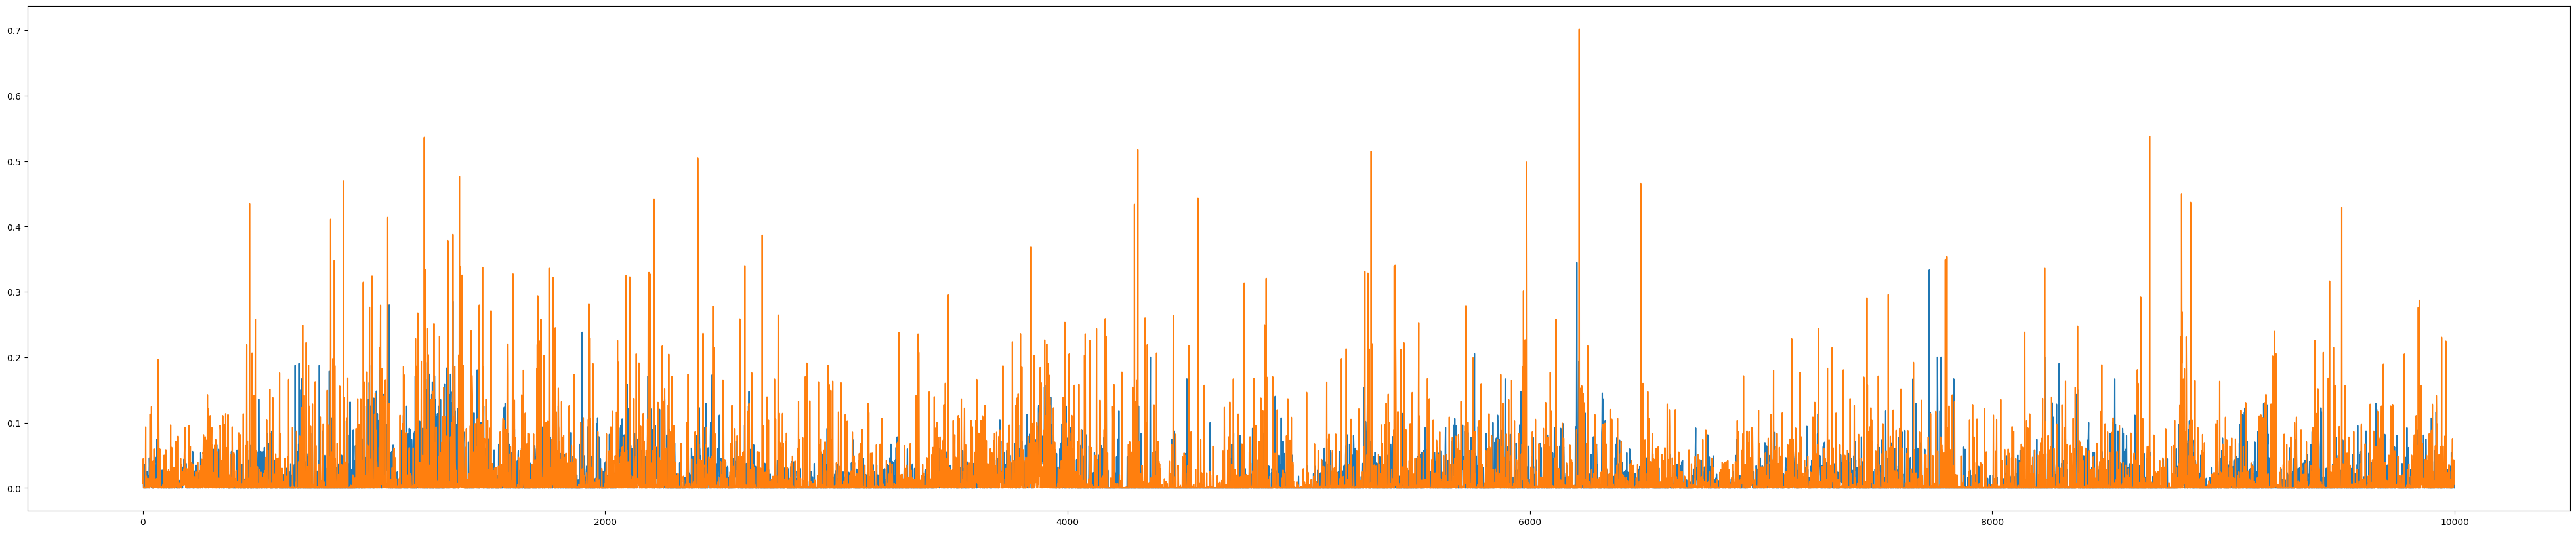

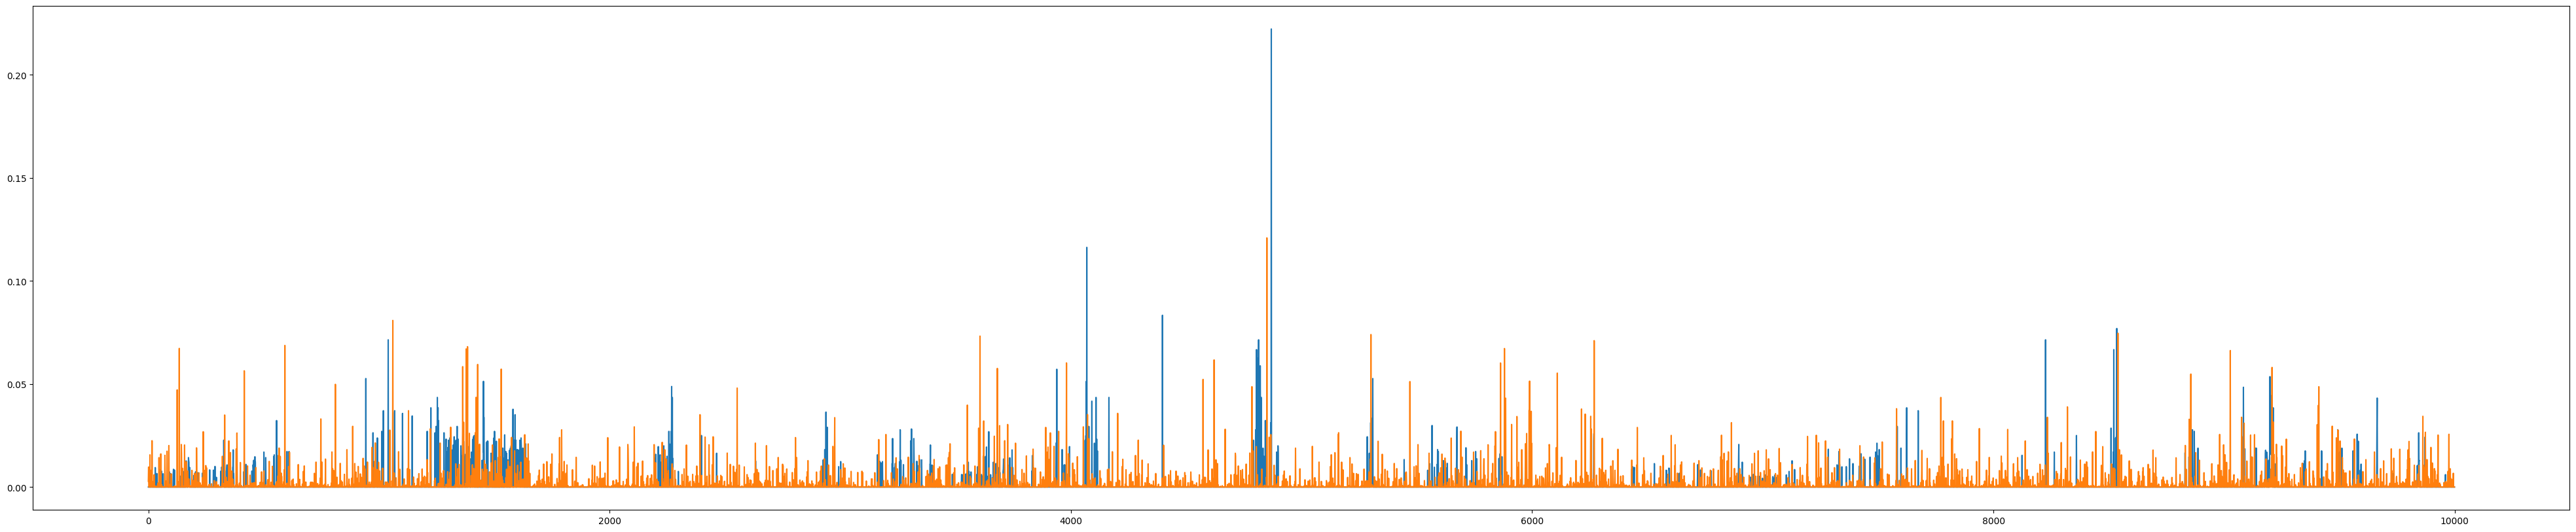

In [8]:
window = 10000
for i in range(13):
    plt.figure(figsize=(50, 10))
    plt.plot(y_test[:window,i])
    if i == 0:
        plt.plot(mu_hat[:window,i])
        plt.plot(mu_hat[:window,i]+sigma_hat[:window,i])
        plt.plot(mu_hat[:window,i]-sigma_hat[:window,i])
    else:
        plt.plot(beta[:window,i])
    plt.show()